#Generating People Faces with CelebA Dataset using PyTorch Lightning

In [ ]:
# Install necessary libraries
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 14.9 MB/s eta 0:00:00


In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

## Data loading

In [ ]:
from datasets import load_dataset

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the CelebA dataset from Hugging Face Hub
celeba_dataset = load_dataset("tglcourse/CelebA-faces-cropped-128", split="test")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/192469 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10130 [00:00<?, ? examples/s]

In [ ]:
# Convert the Hugging Face dataset to PyTorch dataset
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]["image"]

        if self.transform:
            image = self.transform(image.convert("RGB"))

        return image



In [ ]:
len(celeba_dataset)

10130

In [ ]:
# Define the ratio for splitting the dataset
train_ratio = 0.8
val_ratio = 1 - train_ratio

# Calculate the sizes of training and validation datasets
train_size = int(train_ratio * len(celeba_dataset))
val_size = len(celeba_dataset) - train_size

# Split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(celeba_dataset, [train_size, val_size])

print(f"Number of instances: {len(train_dataset)}")
print(f"Number of instances: {len(val_dataset)}")


# Create the PyTorch dataset and data loader
train_set, val_set = CelebADataset(train_dataset, transform=transform), CelebADataset(val_dataset, transform=transform)


# Define batch size
batch_size = 128

# Create separate data loaders for training and validation datasets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)


Number of instances: 8104
Number of instances: 2026


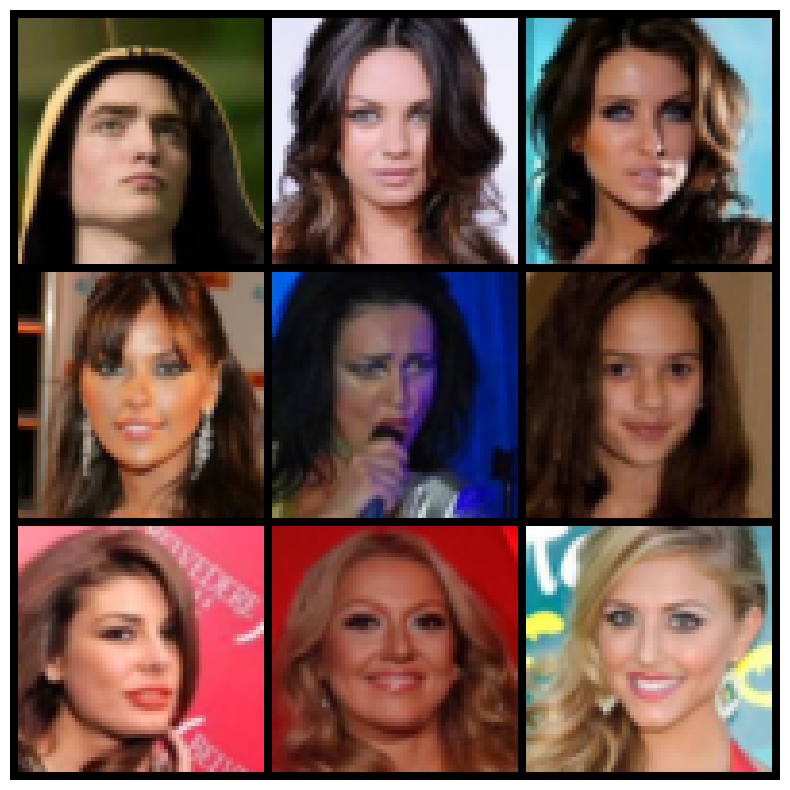

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def plot_images_from_loader(dataloader, nrows, ncols, figsize=(10, 10)):
    # Get a batch of images from the data loader
    images = next(iter(dataloader))
    images = vutils.make_grid(images[:nrows * ncols], nrow=ncols, padding=2, normalize=True)

    # Plot the images
    plt.figure(figsize=figsize)
    plt.imshow(images.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

plot_images_from_loader(train_loader, nrows=3, ncols=3, figsize=(10, 10))


##Autoencoder (AE)


An Autoencoder (AE) is an unsupervised learning algorithm that **aims to learn efficient representations of input data**, typically by compressing it into a lower-dimensional latent space and then **reconstructing the original input** from this compressed representation.

The model consists of an **encoder** network that maps input data to the latent space and a **decoder** network that reconstructs the original data from the latent space representation.

The loss function encourages the reconstructed output to be as close to the input data as possible, promoting effective representation learning.

In [ ]:
from torch.optim import Adam
from torchvision.datasets import ImageFolder

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 4 * 4, 128)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(128, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 4, 4)
        x = nn.functional.relu(self.deconv1(x))
        x = nn.functional.relu(self.deconv2(x))
        x = nn.functional.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))
        return x

class Autoencoder(pl.LightningModule):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def training_step(self, batch, batch_idx):
        x = batch
        recon = self(x)
        loss = self.loss_fn(recon, x)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


In [ ]:
def train_ae(model, train_loader, val_loader, num_epochs=5):
    trainer = pl.Trainer(max_epochs=num_epochs)
    trainer.fit(model, train_loader, val_loader)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_ae(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        # Get a batch of original images and their reconstructions
        original_images = next(iter(dataloader))
        reconstructed_images = model(original_images)

        # Calculate the difference between original and reconstructed images
        diff_images = torch.abs(original_images - reconstructed_images)

        # Plot the original images, reconstructions, and differences
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 3 * num_samples))
        for i in range(num_samples):
            # Original image
            axes[i, 0].imshow(original_images[i].permute(1, 2, 0))
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')

            # Reconstructed image
            axes[i, 1].imshow(reconstructed_images[i].permute(1, 2, 0))
            axes[i, 1].set_title('Reconstructed')
            axes[i, 1].axis('off')

            # Difference image
            axes[i, 2].imshow(diff_images[i].permute(1, 2, 0), cmap='gray')
            axes[i, 2].set_title('Difference')
            axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()


We can interpolate between latent vectors of two different images in the latent space and decode these interpolated vectors to observe smooth transitions between images. This can provide insights into the learned representations.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 359 K 
1 | decoder | Decoder | 361 K 
2 | loss_fn | MSELoss | 0     
------------------------------------
721 K     Trainable params
0         Non-trainable params
721 K     Total params
2.885     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


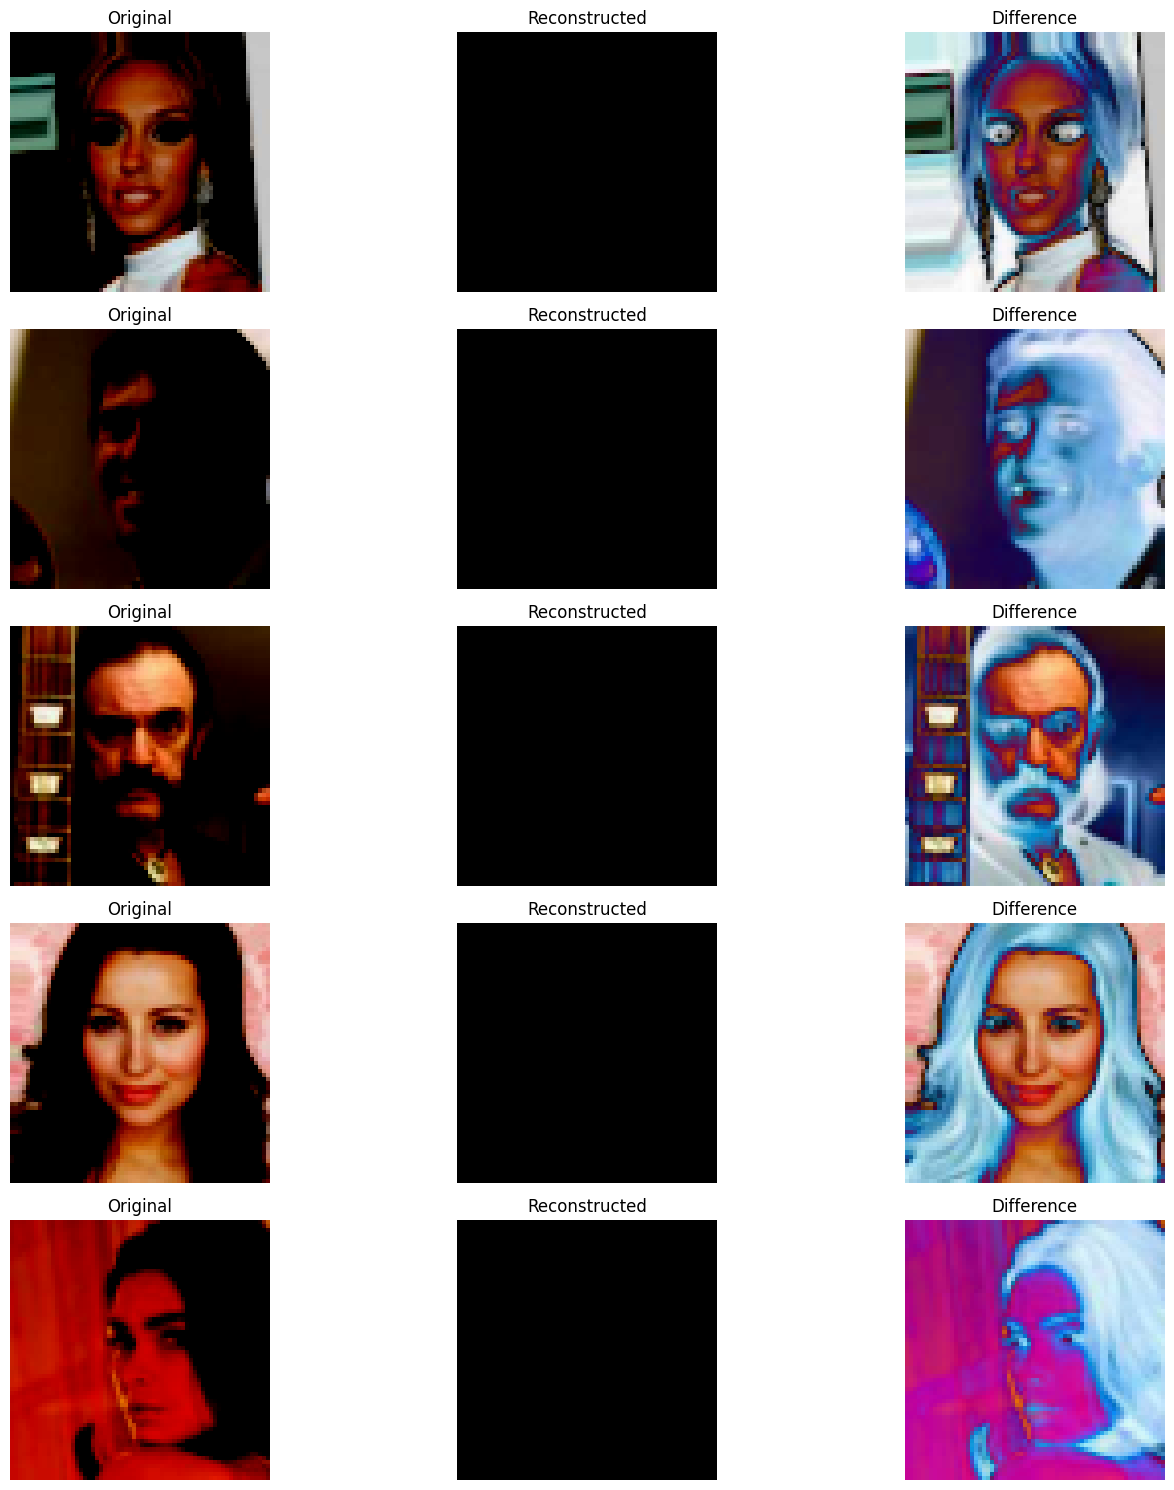

In [ ]:
# Instantiate the AE model
ae_model = Autoencoder()

# Train the AE model
train_ae(ae_model, train_loader, val_loader)

# Visualize AE reconstructions
visualize_ae(ae_model, val_loader)


##Variational Autoencoder (VAE)


A Variational Autoencoder (VAE) is an extension of the Autoencoder (AE) that learns a probabilistic latent space representation of input data.

It models the **latent space as a probability distribution** and trains the model to generate data by sampling from this distribution.

VAE introduces a regularizer term to the loss function that encourages the latent space distribution to approximate a predefined prior distribution, typically a Gaussian distribution. This regularization promotes smoother interpolation and better generalization properties compared to traditional AE.


The loss function for VAE combines a reconstruction loss term and a Kullback-Leibler divergence term:

$$L_{VAE}=reconstruction\_loss + KL\_divergence$$


Where:

*reconstruction_loss* is the binary cross-entropy between the reconstructed output and the input data.

*KL_divergence* is the Kullback-Leibler divergence between the learned latent space distribution and a predefined prior distribution.

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAEEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

class VAE(pl.LightningModule):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = Decoder()
        self.loss_fn = nn.MSELoss(reduction='sum')  # Using sum reduction for VAE loss
        self.latent_dim = latent_dim

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z)

    def vae_loss(self, recon_x, x, mu, log_var):
        reconstruction_loss = self.loss_fn(recon_x, x)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return reconstruction_loss + kl_divergence

    def training_step(self, batch, batch_idx):
        x = batch
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z)
        loss = self.vae_loss(recon_x, x, mu, log_var)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)



[On reparametrization trick (in russain)](https://drive.google.com/file/d/18LWM4jROW6A89B7XEpH6w66M5BomGUKn/view?usp=sharing).

In [ ]:
vae = VAE()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(vae, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | VAEEncoder | 621 K 
1 | decoder | Decoder    | 361 K 
2 | loss_fn | MSELoss    | 0     
---------------------------------------
983 K     Trainable params
0         Non-trainable params
983 K     Total params
3.934     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_vae_results(vae_model, dataloader, num_samples=5):
    vae_model.eval()
    with torch.no_grad():
        # Get a batch of original images and their reconstructions
        original_images = next(iter(dataloader))
        reconstructions = vae_model(original_images)

        # Generate new samples by sampling from the latent space
        latent_samples = torch.randn(num_samples, vae_model.latent_dim)
        generated_images = vae_model.decoder(latent_samples)

        # Plot the original images and their reconstructions
        fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
        for i in range(num_samples):
            # Original image
            axes[i, 0].imshow(original_images[i].permute(1, 2, 0))
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')

            # Reconstructed image
            axes[i, 1].imshow(reconstructions[i].permute(1, 2, 0))
            axes[i, 1].set_title('Reconstructed')
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

        # Plot the generated samples
        fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
        for i in range(num_samples):
            axes[i].imshow(generated_images[i].permute(1, 2, 0))
            axes[i].set_title('Generated')
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()


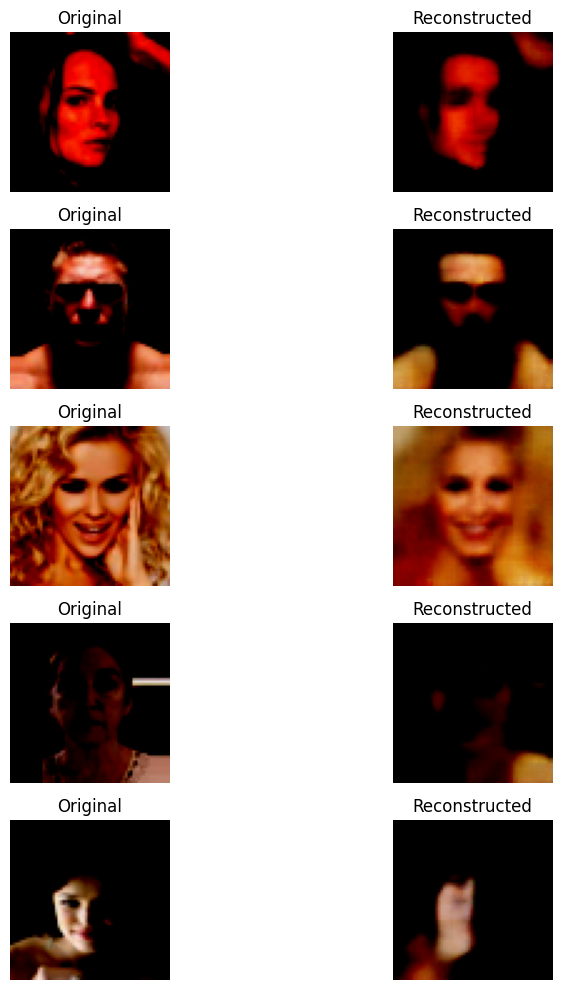

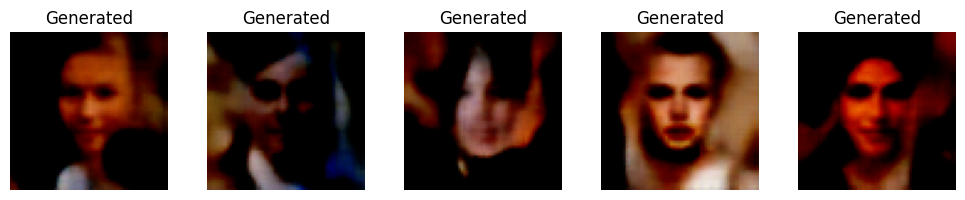

In [ ]:
visualize_vae_results(vae, val_loader)

In this seminar on Generative Models with PyTorch Lightning, we covered the fundamentals of Autoencoders (AEs) and Variational Autoencoders (VAEs). We discussed how these models can learn to generate realistic data samples, such as images, by learning the underlying distribution of the data.

We explored Variational Autoencoders (VAEs), which extend the basic Autoencoder architecture by introducing a probabilistic approach to modeling the latent space. We discussed the encoder-decoder architecture of VAEs and how they can generate new samples by sampling from a learned distribution in the latent space.

Throughout the seminar, we emphasized the use of PyTorch Lightning, a lightweight wrapper for PyTorch, to streamline the training process of generative models. PyTorch Lightning simplifies the implementation of complex neural network architectures and provides built-in support for distributed training, logging, and visualization.

